### EDA

In [1]:
import warnings

from pathlib import Path
from typing import Literal

import nibabel as nib
import numpy as np
import pandas as pd

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from ptp import eda_utils

C:\Users\julia\AppData\Local\Temp\ipykernel_14588\3494291060.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data_dir = Path("../data")
train_generated_dir = data_dir / "generated_part1_nii_gz"
train_real_dir = data_dir / 'real_nii_gz'
test_dir = data_dir / "patch-the-planet-test-data"

Woluminy losowo tasuję, bo statystki obliczam raczej dla pozbiorów z powodu problemów z pomieszczeniem wszystkich danych w pamięci

In [3]:
train_generated_data = [nib.load(path) for path in list(train_generated_dir.glob("*.nii.gz"))]
train_real_data = [nib.load(path) for path in list(train_real_dir.glob("*.nii.gz"))]

np.random.shuffle(train_generated_data)
np.random.shuffle(train_real_data)

In [4]:
len(train_generated_data)

25

In [5]:
len(train_real_data)

50

Generated Image


<img style="width: 50%;" src="../images/slicer_generated.png">
<img style="width: 50%;" src="../images/slicer_generated_2.png">

Real Image 1

<img style="width: 50%;" src="../images/real_data.png">

Real Image (other volume)

<img style="width: 50%;" src="../images/real_data_other.png">

# EDA - Exploratory Data Analysis

## Co warto zrobić?

* Przeprowadźcie analizę wymiarów zestawu danych, uwzględniając liczbę woluminów sejsmicznych oraz charakterystyki przestrzenne każdego woluminu.
* Może warto porównać dane wygenerowane z prawdziwymi danymi, żeby zrozumieć jakie są różnice między nimi. Dla przykładu jakieś basic statystyki jak takie jak średnia, mediana i odchylenie standardowe. 
* Można wygerenerować ilustracyjne przekroju i zobaczyć jak się mają ich statystyki do całego woluminu. Może lepiej brać górne części woluminów, a może dolne lub środkowe lub jeszcze jakąś inną kombinację.
* Można ocenić standardowe 25% brakujących sekcji i zbadaj, jak wpływa on na ogólną strukturę woluminów sejsmicznych.
* Można poszukać jakiś współzależności pomiędzy woluminami prawdziwymi i wygenerowanymi.
* Przede wszystkim poogladajcie sobie te dane w Slicer i zobaczcie jak wyglądają. Zwróćcie uwagę na różnice w teksturze, kształcie, jasności, itp. Te różnice mogą być ważne w kontekście problemu, który chcecie rozwiązać, więc warto się zastanowić jakie cechy są ważne, bo te woluminy w przypadku prawdziwych danych mogą być bardzo różne i zresztą są.
* Weźcie sobie na przykład jakieś charakterystyczne slicy w tych woluminach i zróbcie histogramy. 
* Nie musicie patrzyć jaki jest spacing w tych woluminach i jaki shape mają. Te pliki początkowo było w formacie .npy i Wojtek dla wygody zamienił je na .nii.gz wiec nie będziecie mieli informacji o spacingu, a shape jest chyba taki sam dla wszystkich woluminów.


#### Zapoznawanie się z formatem nib

In [7]:
img = train_generated_data[0]

img.dataobj

In [8]:
img.affine

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [9]:
header = img.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [   3  300  300 1259    1    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y          :

In [10]:
header.get_data_shape()

(300, 300, 1259)

In [11]:
header.get_data_dtype()

dtype('<i2')

In [12]:
header.get_zooms()

(1.0, 1.0, 1.0)

In [13]:
img_array = img.get_fdata()
print(img_array[:, :, 0])

[[  1.   2.  10. ...  -2.  -7.  -9.]
 [  6.   4.   6. ...  -2.  -5.  -4.]
 [  5.   5.   4. ...   4.  -1.  -1.]
 ...
 [-10.  -8.  -4. ...  -2.   2.   1.]
 [ -3.  -6.  -4. ...   0.   5.   3.]
 [  1.  -4.  -6. ...   6.   9.   4.]]


#### Porównanie wizualne przy pomocy slicer'a i matplotlib

Widok 3D dla wygenerowanych danych

<img style="width: 70%;" src="../images/gen_data_full_view.png">

Widok 3D dla prawdziwnych danych

<img style="width: 70%;" src="../images/real_data_full_view.png">

Widać, że przekroje różnią się między sobą - dane wygenerowane są "mniej zaszumione", jednak w niektórych miejscach złączenia są "ostre". Dane prawdziwe są "gęstsze" i to na całej osi głębokości. Natomiast dane wygenerowane mają większe zagęszczenie w środku, a mniejsze na początku.  

##### Wybrane przykłady
Wybrałam do analizy parę woluminów, które najpierw przejrzałam w slicerze, a potem zilustrowałam je niżej dla ciekawszych przekrojów. 

In [39]:
gen_examples = [
    nib.load(train_generated_dir / 'seismicCubes_RFC_fullstack_2023.76346560.nii.gz'),
    nib.load(train_generated_dir / 'seismicCubes_RFC_fullstack_2023.76346962.nii.gz'), 
    nib.load(train_generated_dir / 'seismicCubes_RFC_fullstack_2023.76346988.nii.gz'),
]
real_examples = [
    nib.load(train_real_dir / '5pwxk3jblh.nii.gz'),
    nib.load(train_real_dir / 'b0efvd3qil.nii.gz'),
]

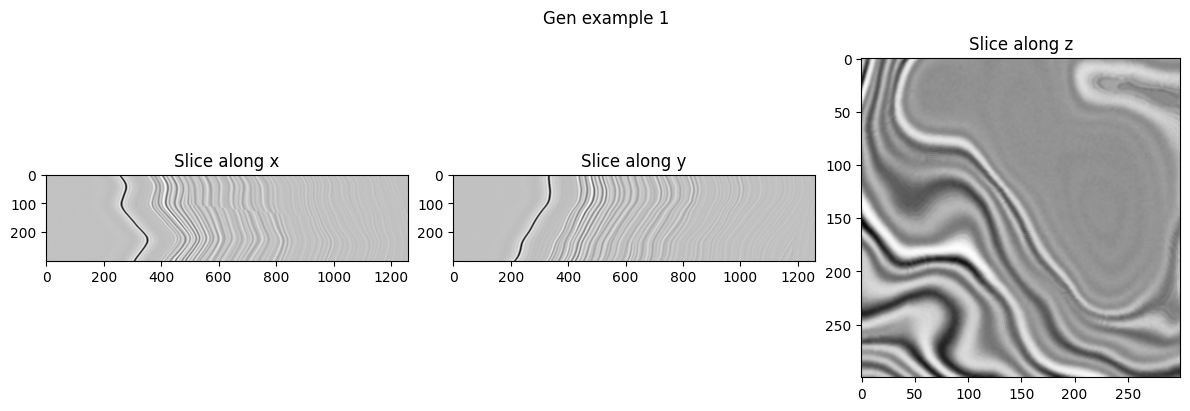

In [9]:
eda_utils.visualize_slices(gen_examples[0], 150, 150, 400, 'Gen example 1')

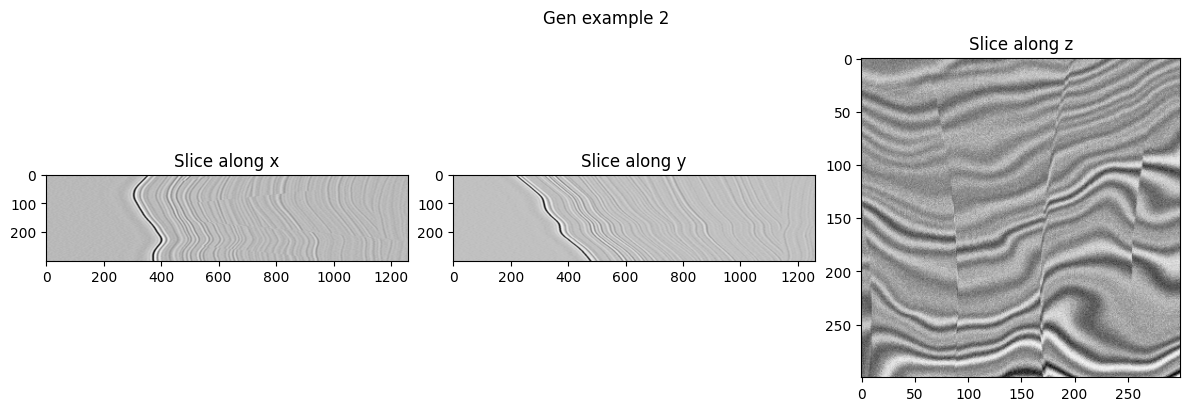

In [10]:
eda_utils.visualize_slices(gen_examples[1], 150, 150, 630, 'Gen example 2')

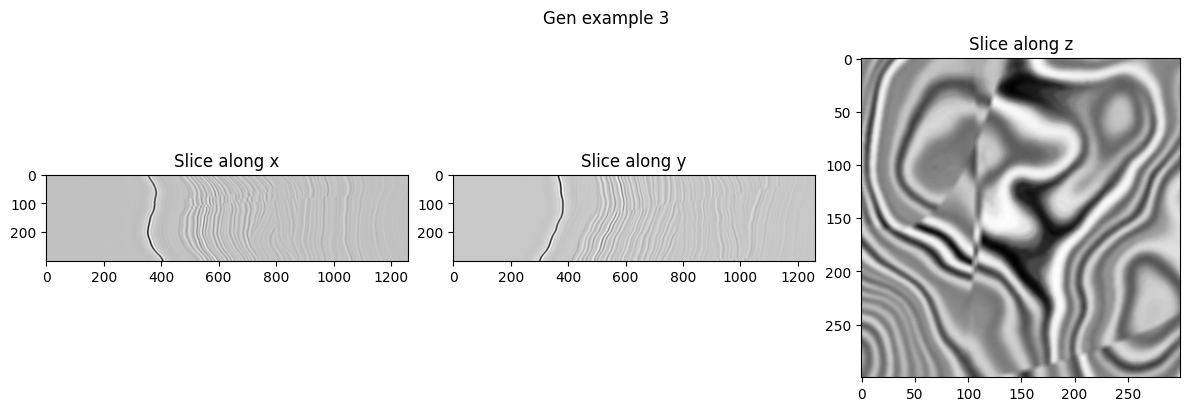

In [11]:
eda_utils.visualize_slices(gen_examples[2], 130, 78, 550, 'Gen example 3')

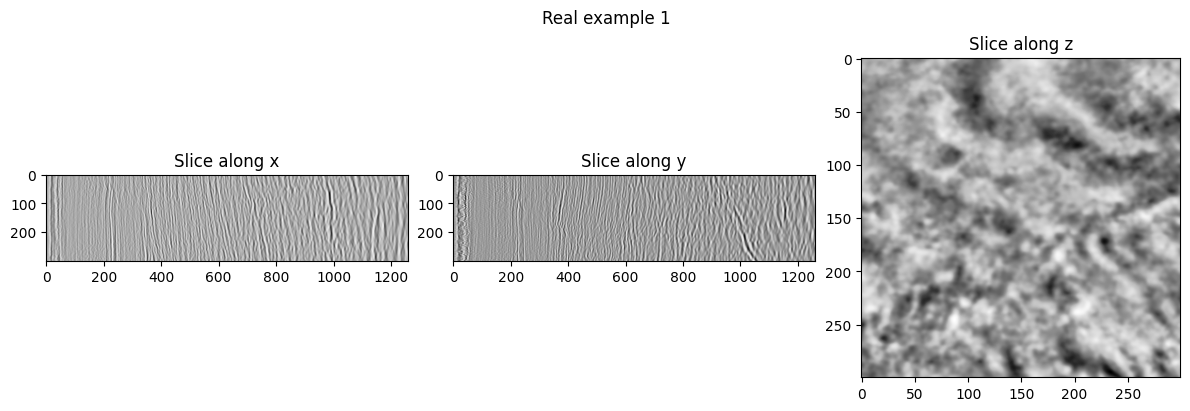

In [12]:
eda_utils.visualize_slices(real_examples[0], 150, 150, 400, 'Real example 1')

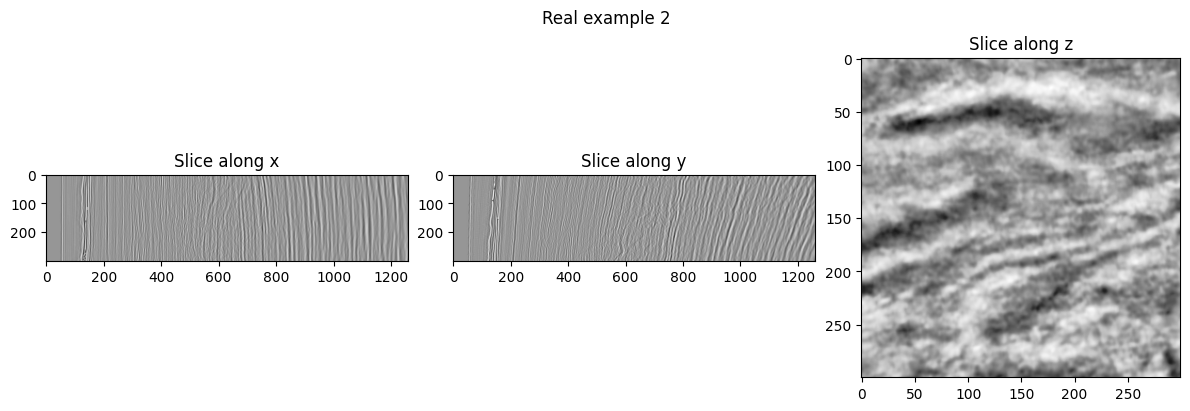

In [13]:
eda_utils.visualize_slices(real_examples[1], 250, 66, 540, 'Real example 2')

#### Analiza przekrojów wzdłuż różnych osi
Następnie dla jednego przykładu z wybranych wyżej przeanalizowałam wartości, średnie i odchylenia wzdłuż wybranych osi

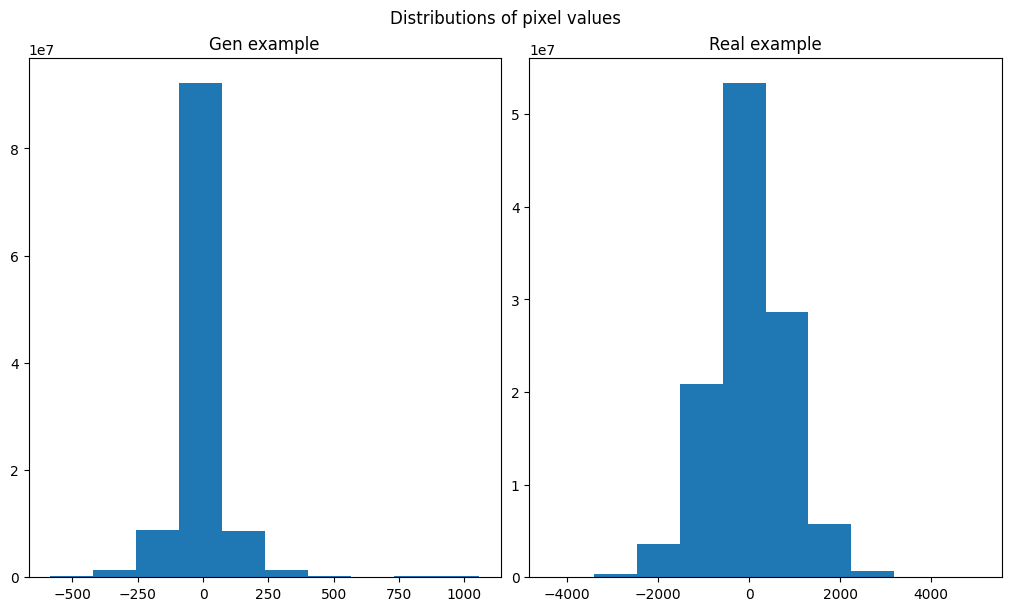

In [48]:
plt.figure(figsize=(10, 6), constrained_layout=True)
plt.suptitle('Distributions of pixel values')
plt.subplot(1, 2, 1)
plt.title('Gen example')
plt.hist(gen_examples[0].get_fdata().flatten())
plt.subplot(1, 2, 2)
plt.title('Real example')
_ = plt.hist(real_examples[0].get_fdata().flatten())

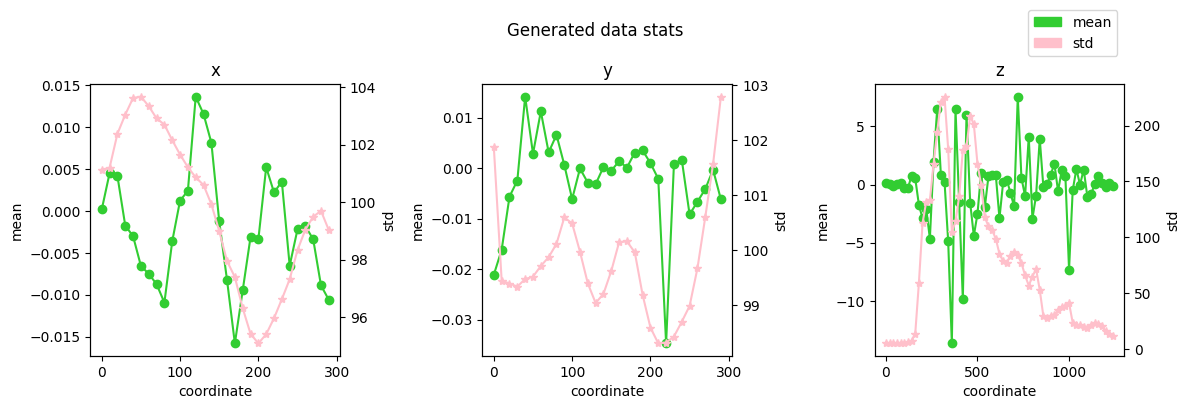

Across x: mean = -0.00, std = 0.01
Across y: mean = -0.00, std = 0.01
Across z: mean = -0.34, std = 3.29


In [16]:
gen_stats_x = eda_utils.compute_stats_along_x(gen_examples[:1], np.arange(0, 300, 10))
gen_stats_y = eda_utils.compute_stats_along_y(gen_examples[:1], np.arange(0, 300, 10))
gen_stats_z = eda_utils.compute_stats_along_z(gen_examples[:1], np.arange(0, 1260, 20))

fig, (ax_x, ax_y, ax_z) = plt.subplots(1, 3, figsize=(12, 4))

std_patch = mpatches.Patch(color='pink', label='std')
mean_patch = mpatches.Patch(color='limegreen', label='mean')

fig.suptitle('Generated data stats')
ax_x, ax_x2 = eda_utils.plot_mean_and_std(gen_stats_x, ax_x, 'x')
ax_y, ax_y2 = eda_utils.plot_mean_and_std(gen_stats_y, ax_y, 'y')
ax_z, ax_z2 = eda_utils.plot_mean_and_std(gen_stats_z, ax_z, 'z')

plt.tight_layout()
plt.legend(handles=[mean_patch, std_patch], bbox_to_anchor=(1, 1.3))
plt.show()

print(f'Across x: mean = {np.mean(gen_stats_x["mean"]):.2f}, std = {np.std(gen_stats_x["mean"]):.2f}')
print(f'Across y: mean = {np.mean(gen_stats_y["mean"]):.2f}, std = {np.std(gen_stats_y["mean"]):.2f}')
print(f'Across z: mean = {np.mean(gen_stats_z["mean"]):.2f}, std = {np.std(gen_stats_z["mean"]):.2f}')

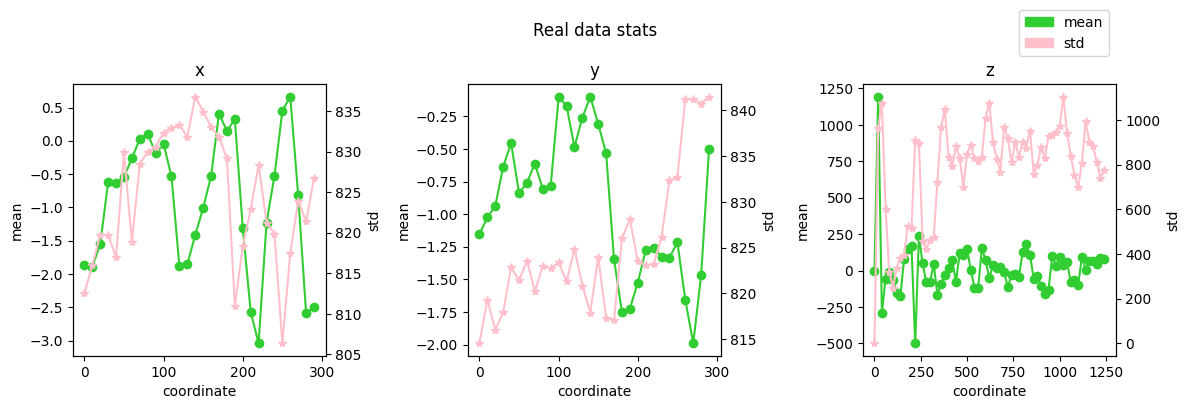

Across x: mean = -0.91, std = 1.01
Across y: mean = -0.95, std = 0.52
Across z: mean = 13.73, std = 191.66


In [17]:
real_stats_x = eda_utils.compute_stats_along_x(real_examples[:1], np.arange(0, 300, 10))
real_stats_y = eda_utils.compute_stats_along_y(real_examples[:1], np.arange(0, 300, 10))
real_stats_z = eda_utils.compute_stats_along_z(real_examples[:1], np.arange(0, 1260, 20))

fig, (ax_x, ax_y, ax_z) = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle('Real data stats')
ax_x, ax_x2 = eda_utils.plot_mean_and_std(real_stats_x, ax_x, 'x')
ax_y, ax_y2 = eda_utils.plot_mean_and_std(real_stats_y, ax_y, 'y')
ax_z, ax_z2 = eda_utils.plot_mean_and_std(real_stats_z, ax_z, 'z')

plt.tight_layout()
plt.legend(handles=[mean_patch, std_patch], bbox_to_anchor=(1, 1.3))
plt.show()

print(f'Across x: mean = {np.mean(real_stats_x["mean"]):.2f}, std = {np.std(real_stats_x["mean"]):.2f}')
print(f'Across y: mean = {np.mean(real_stats_y["mean"]):.2f}, std = {np.std(real_stats_y["mean"]):.2f}')
print(f'Across z: mean = {np.mean(real_stats_z["mean"]):.2f}, std = {np.std(real_stats_z["mean"]):.2f}')

### EDA

#### Analiza wymiarów

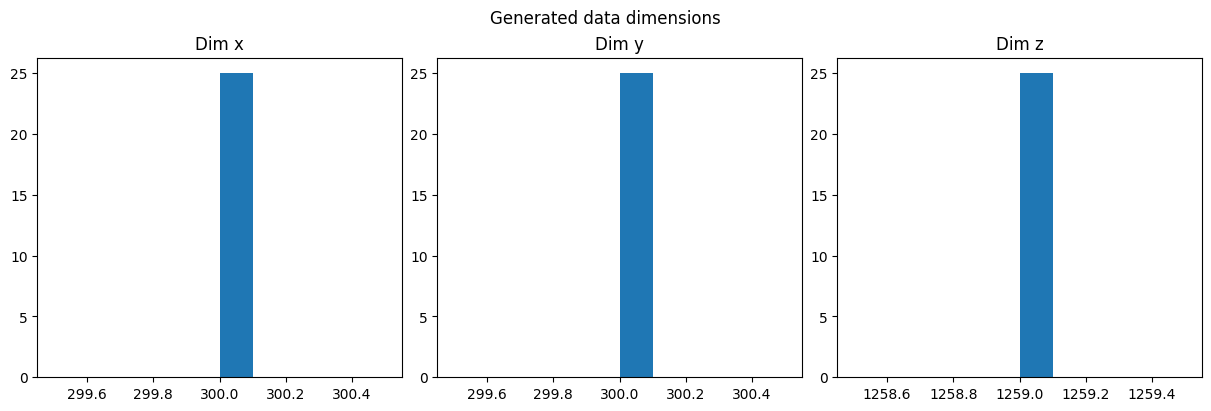

In [18]:
eda_utils.plot_spacial_dim_dist(train_generated_data, 'Generated data dimensions')

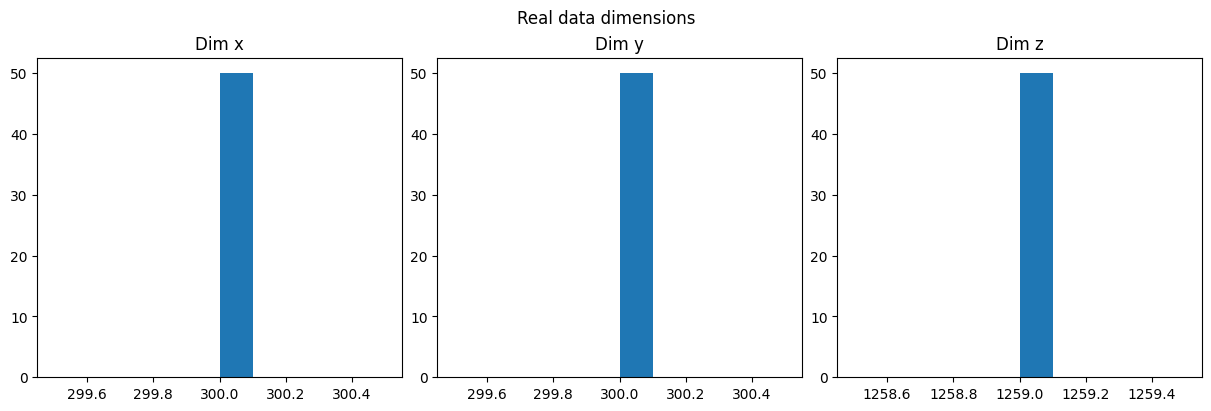

In [19]:
eda_utils.plot_spacial_dim_dist(train_real_data, 'Real data dimensions')

Bez zaskoczenia wymiary są takie same: 300 x 300 x 1259

### Statystyki

#### Analiza pojedynczych woluminów 
Tj. średnie i odchylenia dla każdego z woluminów

In [20]:
gen_means = [np.mean(img.get_fdata()) for img in train_generated_data]
gen_stds = [np.std(img.get_fdata()) for img in train_generated_data]

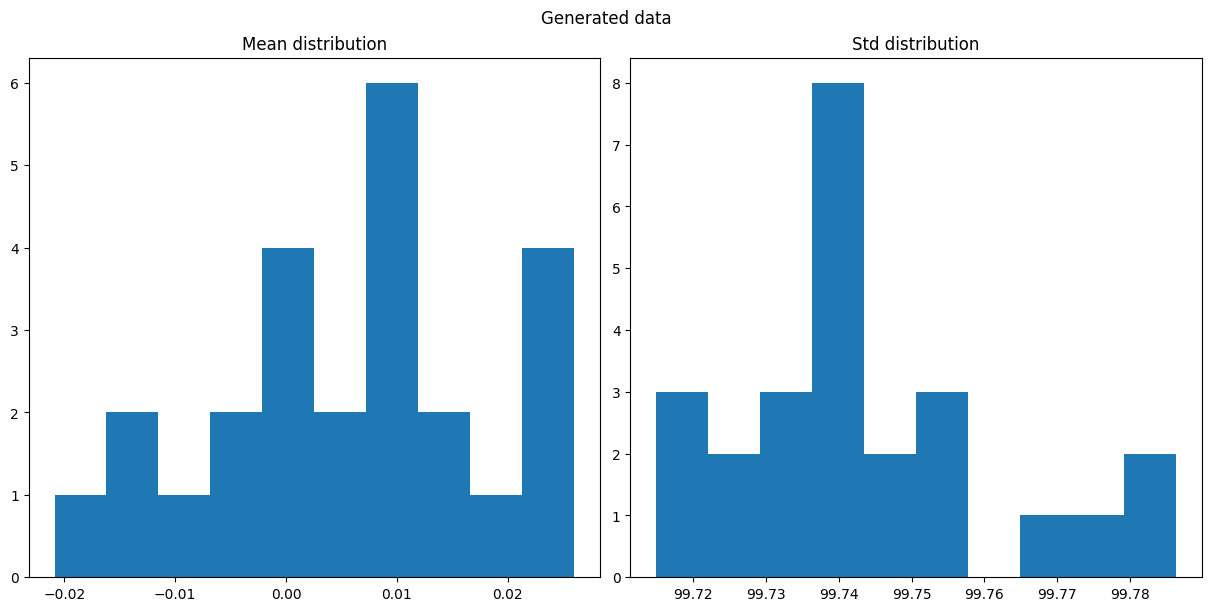

In [21]:
eda_utils.plot_mean_and_std_dist(gen_means, gen_stds, 'Generated data')

Tutaj użyłam połowę zbioru

In [22]:
real_means = [np.mean(img.get_fdata().astype(np.float32))for img in train_real_data[::2]]
real_stds = [np.std(img.get_fdata().astype(np.float32)) for img in train_real_data[::2]]

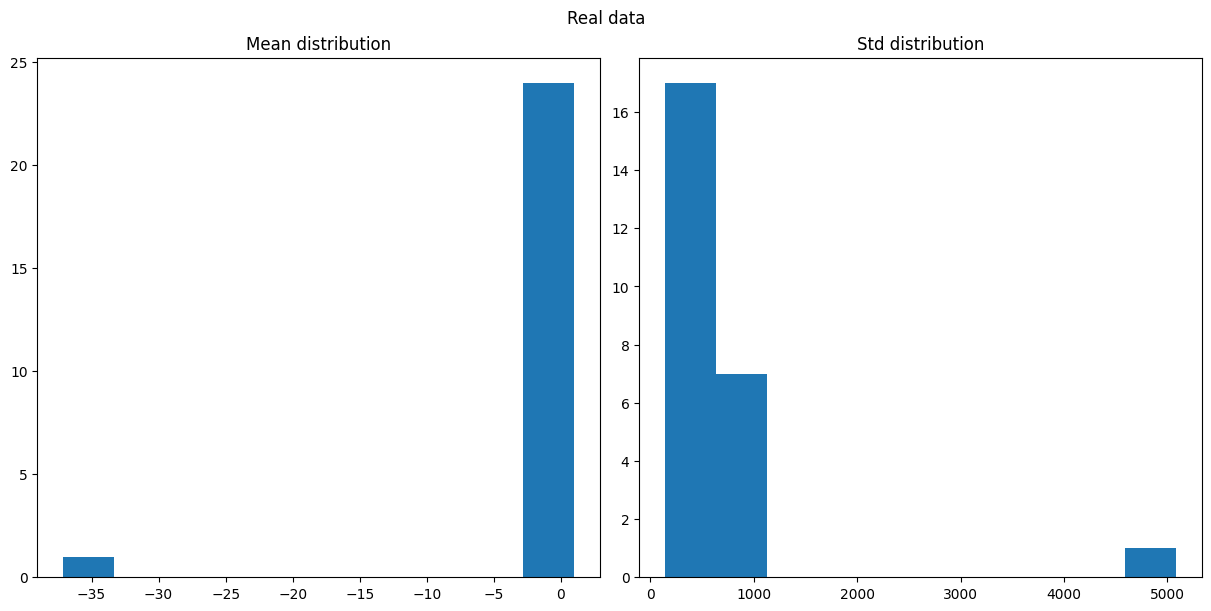

In [23]:
eda_utils.plot_mean_and_std_dist(real_means, real_stds, 'Real data')

Jako że statystyki powyżej mają outlier'y to zamieściłam też rozkład bez tych wartości skrajnych

In [27]:
real_mean_ww_outliers = [m for m in real_means if m > np.percentile(real_means, 0.75)]
real_std_ww_outliers = [s for s in real_stds if s < max(real_stds)]

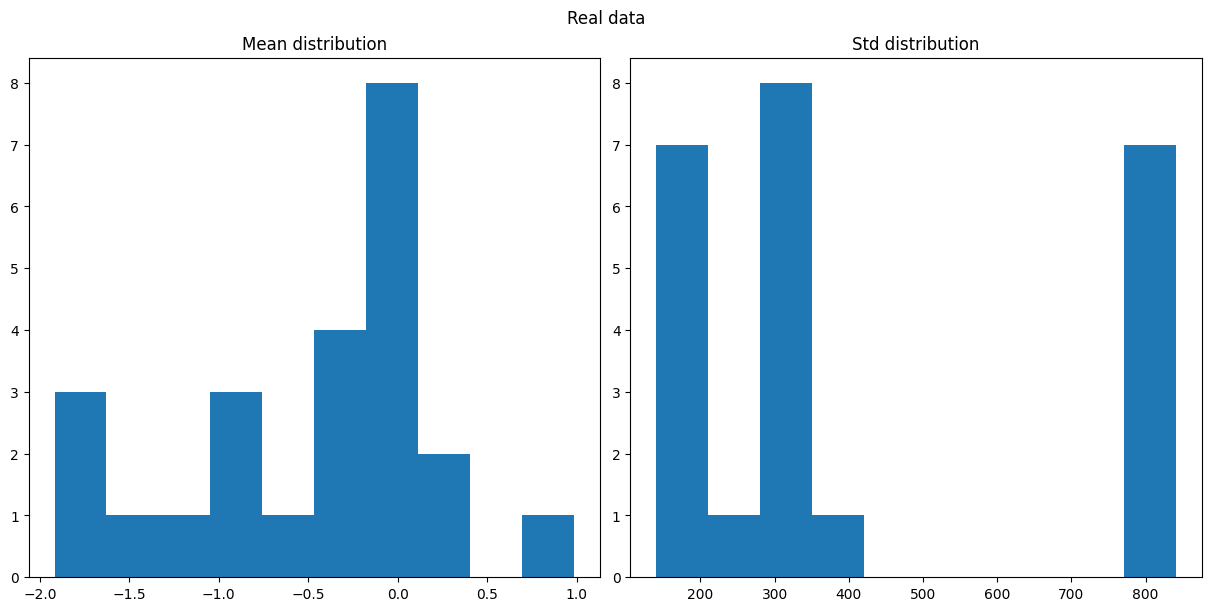

In [28]:
eda_utils.plot_mean_and_std_dist(real_mean_ww_outliers,
                        real_std_ww_outliers, 'Real data')

<BarContainer object of 2 artists>

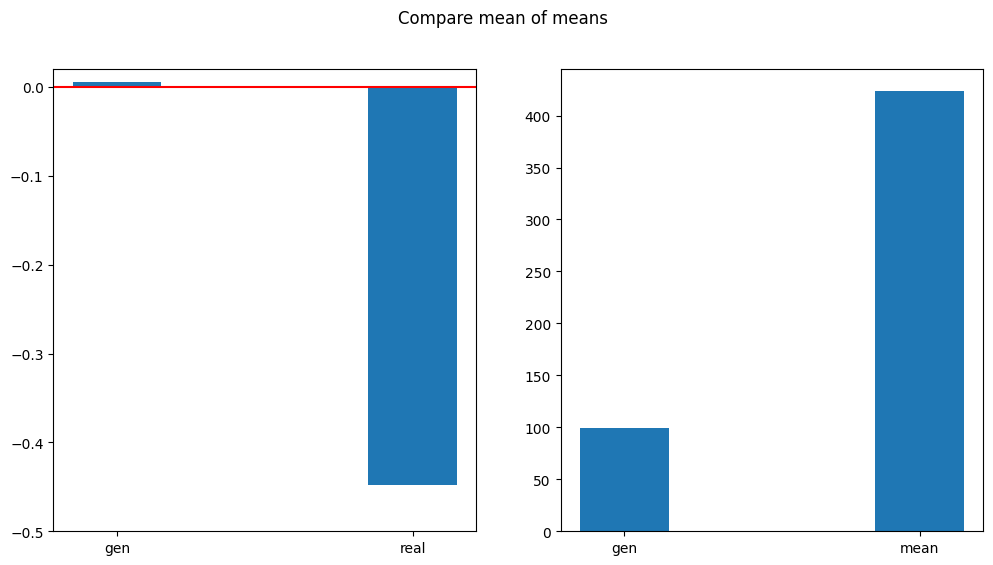

In [37]:
plt.figure(figsize=(12, 6))
plt.suptitle('Compare mean of means')
plt.subplot(1, 2, 1)
plt.ylim(-0.5, 0.02)
plt.hlines([0], [-3], [3], colors=['red'])
plt.bar(['gen', 'real'], [np.mean(gen_means), np.mean(real_mean_ww_outliers)], width=0.3)
plt.subplot(1, 2, 2)
# plt.hlines([0], [-3], [3], colors=['red'])
plt.bar(['gen', 'mean'], [np.mean(gen_stds), np.mean(real_std_ww_outliers)], width=0.3)

In [4]:
GEN_SPACING = 2
REAL_SPACING = 4

Myślę jednak, że jeśli to są dane przestrzenne to warto obliczać statystyki dla jakiś przekrojów wzdłuż jednej z osi. 

In [5]:
gen_stats_x = eda_utils.compute_stats_along_x(train_generated_data[::GEN_SPACING], [0, 50, 100, 150, 200, 250, 299])
gen_stats_y = eda_utils.compute_stats_along_y(train_generated_data[::GEN_SPACING], [0, 50, 100, 150, 200, 250, 299])
gen_stats_z = eda_utils.compute_stats_along_z(train_generated_data[::GEN_SPACING], [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1258])

Idk czy dobrze ze te punkty połączyłam xd

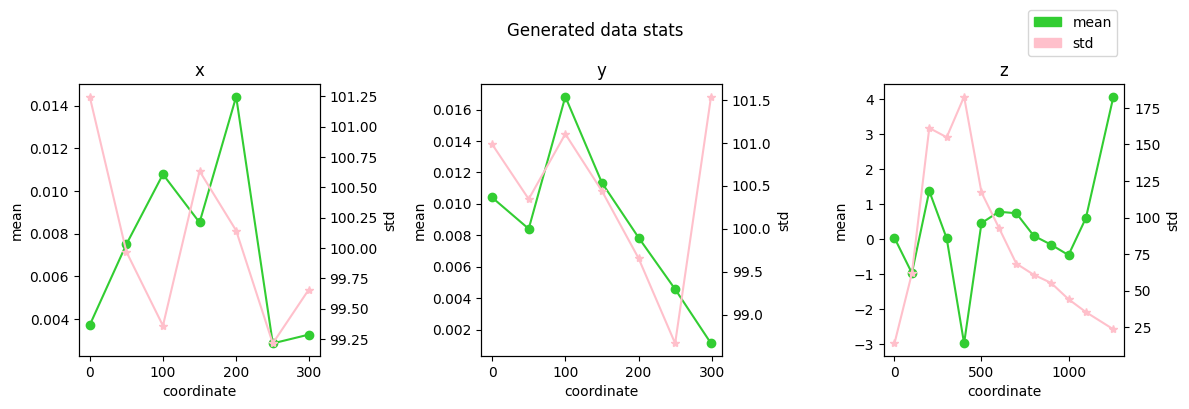

In [7]:
fig, (ax_x, ax_y, ax_z) = plt.subplots(1, 3, figsize=(12, 4))

std_patch = mpatches.Patch(color='pink', label='std')
mean_patch = mpatches.Patch(color='limegreen', label='mean')

fig.suptitle('Generated data stats')
ax_x, ax_x2 = eda_utils.plot_mean_and_std(gen_stats_x, ax_x, 'x')
ax_y, ax_y2 = eda_utils.plot_mean_and_std(gen_stats_y, ax_y, 'y')
ax_z, ax_z2 = eda_utils.plot_mean_and_std(gen_stats_z, ax_z, 'z')

plt.tight_layout()
plt.legend(handles=[mean_patch, std_patch], bbox_to_anchor=(1, 1.3))
plt.show()

In [8]:
real_stats_x = eda_utils.compute_stats_along_x(train_real_data[::REAL_SPACING], [0, 50, 100, 150, 200, 250, 299])
real_stats_y = eda_utils.compute_stats_along_y(train_real_data[::REAL_SPACING], [0, 50, 100, 150, 200, 250, 299])
real_stats_z = eda_utils.compute_stats_along_z(train_real_data[::REAL_SPACING], [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1258])

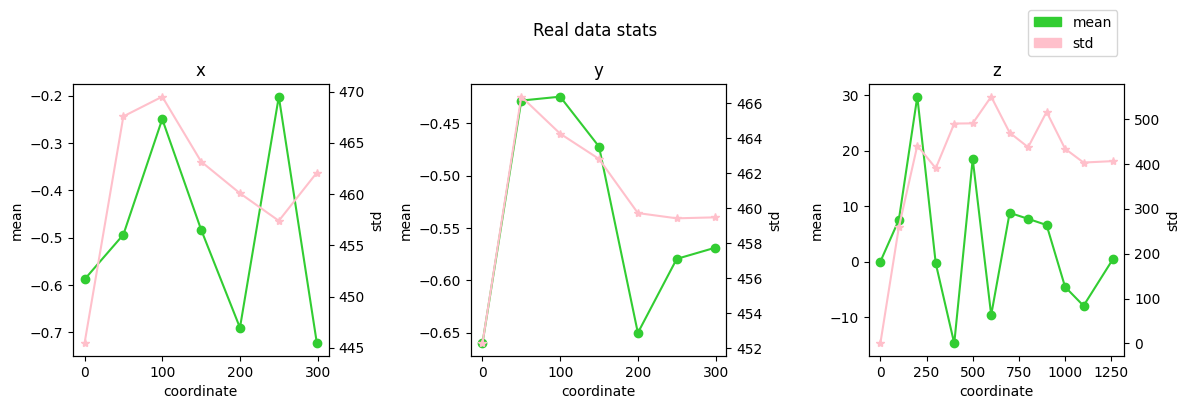

In [67]:
fig, (ax_x, ax_y, ax_z) = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle('Real data stats')
ax_x, ax_x2 = eda_utils.plot_mean_and_std(real_stats_x, ax_x, 'x')
ax_y, ax_y2 = eda_utils.plot_mean_and_std(real_stats_y, ax_y, 'y')
ax_z, ax_z2 = eda_utils.plot_mean_and_std(real_stats_z, ax_z, 'z')

plt.tight_layout()
plt.legend(handles=[mean_patch, std_patch], bbox_to_anchor=(1, 1.3))
plt.show()

In [13]:
import seaborn as sns

In [28]:
stats_x = pd.concat([gen_stats_x.rename({c: 'gen_' + c for c in gen_stats_x.columns}, axis=1), real_stats_x.rename({c: 'real_' + c for c in real_stats_x.columns}, axis=1)], axis=1)
stats_y = pd.concat([gen_stats_y.rename({c: 'gen_' + c for c in gen_stats_y.columns}, axis=1), real_stats_y.rename({c: 'real_' + c for c in real_stats_y.columns}, axis=1)], axis=1)
stats_z = pd.concat([gen_stats_z.rename({c: 'gen_' + c for c in gen_stats_z.columns}, axis=1), real_stats_z.rename({c: 'real_' + c for c in real_stats_z.columns}, axis=1)], axis=1)

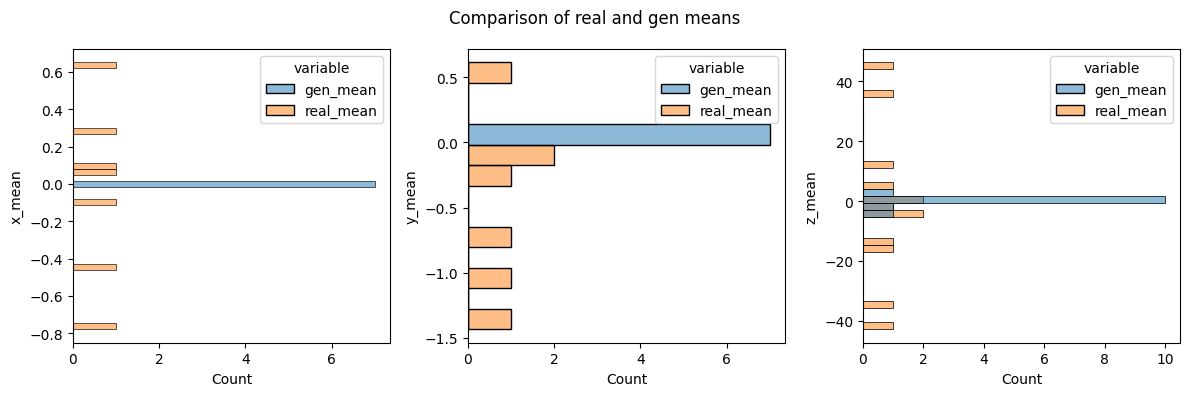

In [36]:
fig, (ax_x, ax_y, ax_z) = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle('Comparison of real and gen means')
sns.histplot(data=stats_x[['gen_mean', 'real_mean']].melt().rename({'value': 'x_mean'}, axis=1), y='x_mean', 
             hue='variable', ax=ax_x)
sns.histplot(data=stats_y[['gen_mean', 'real_mean']].melt().rename({'value': 'y_mean'}, axis=1), y='y_mean', 
             hue='variable', ax=ax_y)
sns.histplot(data=stats_z[['gen_mean', 'real_mean']].melt().rename({'value': 'z_mean'}, axis=1), y='z_mean', 
             hue='variable', ax=ax_z)
plt.tight_layout()

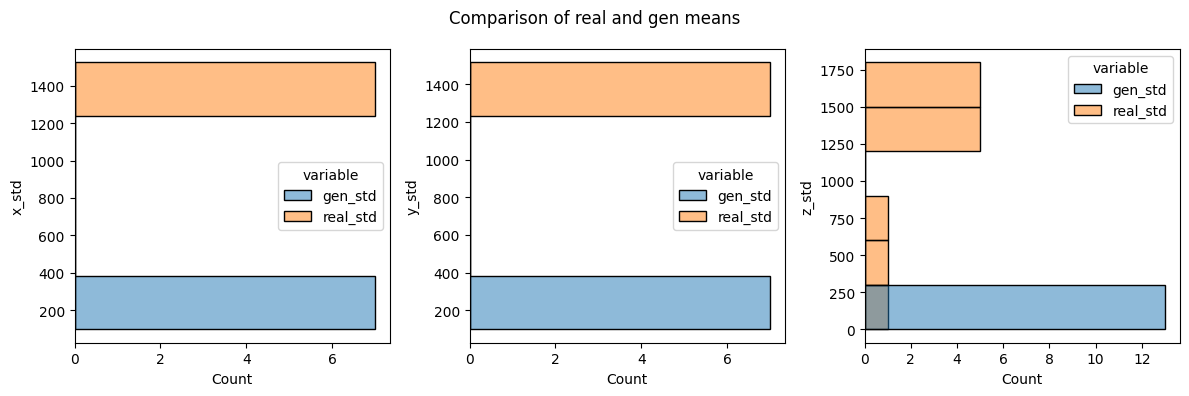

In [37]:
fig, (ax_x, ax_y, ax_z) = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle('Comparison of real and gen means')
sns.histplot(data=stats_x[['gen_std', 'real_std']].melt().rename({'value': 'x_std'}, axis=1), y='x_std', 
             hue='variable', ax=ax_x)
sns.histplot(data=stats_y[['gen_std', 'real_std']].melt().rename({'value': 'y_std'}, axis=1), y='y_std', 
             hue='variable', ax=ax_y)
sns.histplot(data=stats_z[['gen_std', 'real_std']].melt().rename({'value': 'z_std'}, axis=1), y='z_std', 
             hue='variable', ax=ax_z)
plt.tight_layout()

Ogólnie widać, że statystyki różnią się

>a) wzdłuż osi x, y, z: dla x i y średnie są bliskie 0 a wariancje zbliżone, dla z średnie są dalej oddalone od 0 i większą zmienność wariancji

>b) dane prawdziwe mają na ogół większe średnie wzdłuż odpowiadających osi niż wygenerowane i większą wariancję (rzędu ~10)

Ogólnie ta wariancja może wpływać na to jak model będzie się uczyć na prawdziwych i wygenerowanych danych.

### Generowanie woluminów z brakującymi danymi

In [37]:
from ptp.utils import training_data_generator, scoring, create_submission

Wzorując się na starterowym notebook'u wygenerowałam dwa przykłady z brakującymi fragmentami (użyłam domyślnej wartości .25)

Z opcją 'x_line'

<img style="width: 50%;" src="../images/gen_with_missing_volume.png">

<hr/>

Z opcją 'i_line'

<img style="width: 50%;" src="../images/gen_with_missing_volume_i.png">

Co może być istotne to to, że brakujące fragmenty występują tylko wzdłuż tej najdłuższej osi, czyli nie będzie brakujących części na głębokość.

Ciekawy artykuł który opisuje problem <a href="https://arxiv.org/pdf/2204.03197v5.pdf">Adversarial-Learning-based 3-D
 Seismic Data Interpolation and Reconstruction</a>